In [1]:
import pandas as pd
import json
from urllib.request import urlopen
from bs4 import BeautifulSoup as BS
import datetime
import pandas as pd
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf
#from datetime import datetime

190.91000400000001

In [35]:
OPTIONS_API_URL = "https://query2.finance.yahoo.com/v7/finance/options/"
OPTIONS_WEB_URL = "https://finance.yahoo.com/quote/"


ticker = "AAPL"

date_now = datetime.datetime.now().date()
df = yf.download([ticker], start=date_now)#['Adj Close']
price =df["Adj Close"].tolist()[0]

print("Calculando para "+ ticker+ " con precio actual de : "+str(price))

def get_list_dates(ticker):
    # get expiration dates for a given ticker
    url = OPTIONS_API_URL + ticker
    usock = urlopen(url)
    data = usock.read()
    usock.close()
    soup = BS(data,"lxml")
    python_dict = json.loads(soup.getText())
    list_dates=python_dict['optionChain']['result'][0]['expirationDates']
    return list_dates

def get_options(ticker):
    # get all expiration option contracts for a given ticker
    call = pd.DataFrame()
    put = pd.DataFrame()
    name1 = ticker.replace('WIKI/', '')
    list_dates = get_list_dates(ticker)

    for j in list_dates:
        try:
            calls = pd.read_html(OPTIONS_WEB_URL + ticker + "/options?p=" + ticker + "&date=" + str(j))[0]
            calls["expiration"] = datetime.datetime.fromtimestamp(int(j)).strftime('%Y-%m-%d')
            call = call.append(calls)
        except Exception as err: print("Error: {0} : ".format(err)+str(datetime.datetime.fromtimestamp(int(j)).strftime('%Y-%m-%d'))+" call")
        try:
            puts = pd.read_html(OPTIONS_WEB_URL + ticker + "/options?p=" + ticker + "&date=" + str(j))[1]
            puts["expiration"] = datetime.datetime.fromtimestamp(int(j)).strftime('%Y-%m-%d')
            put = put.append(puts)
        except Exception as err: print("Error: {0} : ".format(err)+str(datetime.datetime.fromtimestamp(int(j)).strftime('%Y-%m-%d'))+" put")
            
    call["type"], put["type"] = "call", "put"
    
    final = call.append(put)
    final["ticker"] = ticker
    
    return final

def flatten_multi_index(df):
    mi = df.columns
    suffixes, prefixes = mi.levels
    col_names = [prefixes[i_p] + '_' + suffixes[i_s] for (i_s, i_p) in zip(*mi.labels)]
    df.columns = col_names
    return df

[*********************100%***********************]  1 of 1 downloaded
Calculando para AAPL con precio actual de : 190.91000400000001


In [3]:
options_res = get_options(ticker)

In [4]:
#options_clean.head()

In [5]:

options_clean = options_res.copy()
options_clean.reset_index(drop=True, inplace=True)
# convert strings to numbers
options_clean['% Change'] = options_clean['% Change'].str.replace('%','').replace('-',0).astype(float) / 100
options_clean['Implied Volatility'] = options_clean['Implied Volatility'].str.replace('%','').str.replace(',','').replace('-',0).astype(float) / 100

# convert to dates
options_clean['Last Trade Date'] = pd.to_datetime(options_clean['Last Trade Date'])
options_clean['expiration'] = pd.to_datetime(options_clean['expiration'])

# ITM filter
options_clean['ITM'] = 0
options_clean.loc[options_clean[(options_clean['type'] == 'call') & (options_clean['Strike'] < price)].index, 'ITM'] = 1
options_clean.loc[options_clean[(options_clean['type'] == 'put') & (options_clean['Strike'] > price)].index, 'ITM'] = 1

# 0 for Monday and 6 for Sunday
options_clean['LT_WeekDay'], options_clean['LT_Hour'] = \
options_clean['Last Trade Date'].dt.dayofweek, \
options_clean['Last Trade Date'].dt.hour

# calcuates Bid/Ask spreads
options_clean['B/A Spread'] = options_clean['Ask'] - options_clean['Bid']
options_clean['B/A Spread %'] = options_clean['B/A Spread'] / options_clean['Bid']

calls_itm, puts_itm = options_clean[(options_clean['type'] == 'call') & (options_clean['Strike'] < price)].Strike.count(), \
options_clean[(options_clean['type'] == 'put') & (options_clean['Strike'] > price)].Strike.count()
total, ITM = options_res.Strike.count(), options_clean[options_clean.ITM == 1].ITM.count()
assert ITM == calls_itm + puts_itm

# delete inf values in B/A Spread %
#options_clean=options_clean.replace([np.inf, -np.inf], np.nan).dropna(subset=["B/A Spread %"] ,how="all")

options_clean.head()

/home/ubuntu/.local/lib/python3.5/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,expiration,type,ticker,ITM,LT_WeekDay,LT_Hour,B/A Spread,B/A Spread %
0,AAPL180720C00002500,2018-07-12 14:53:00,2.5,188.50,188.70,188.95,0.00,0.0000,104,1667,20.3750,2018-07-20,call,AAPL,1,3,14,0.25,0.001325
1,AAPL180720C00005000,2018-06-27 09:40:00,5.0,180.88,180.05,181.00,-3.01,-0.0164,13,264,0.0000,2018-07-20,call,AAPL,1,2,9,0.95,0.005276
2,AAPL180720C00010000,2018-05-25 23:55:00,10.0,177.15,178.25,179.00,0.00,0.0000,7,7,0.0000,2018-07-20,call,AAPL,1,4,23,0.75,0.004208
3,AAPL180720C00022500,2018-07-11 15:16:00,22.5,165.50,168.35,169.35,0.00,0.0000,6,7,8.8633,2018-07-20,call,AAPL,1,2,15,1.00,0.005940
4,AAPL180720C00040000,2018-05-11 23:49:00,40.0,149.91,147.95,149.35,0.00,0.0000,40,0,0.0000,2018-07-20,call,AAPL,1,4,23,1.40,0.009463


In [6]:
#options_clean[options_clean.type=="put"]

In [7]:
#pd.pivot_table(aux_options, values=['Open Interest'], index=['expiration'],columns=['type'], aggfunc=np.sum,margins=True)#.sort_values(["Open Interest"]["All"])
#options_clean.head()

In [8]:
#options_clean=pd.read_csv("SPY_options.csv")

In [9]:
options_clean[options_clean.expiration=="2020-06-19"]

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,expiration,type,ticker,ITM,LT_WeekDay,LT_Hour,B/A Spread,B/A Spread %
537,AAPL200619C00085000,2018-07-13 15:58:00,85.0,106.80,104.50,108.95,1.43,0.0136,1,67,0.4313,2020-06-19,call,AAPL,1,4,15,4.45,0.042584
538,AAPL200619C00090000,2018-07-13 11:53:00,90.0,102.45,101.50,102.55,1.45,0.0144,3,68,0.3490,2020-06-19,call,AAPL,1,4,11,1.05,0.010345
539,AAPL200619C00095000,2018-06-26 15:25:00,95.0,91.50,90.00,94.00,0.00,0.0000,1,64,0.0000,2020-06-19,call,AAPL,1,1,15,4.00,0.044444
540,AAPL200619C00100000,2018-07-12 10:32:00,100.0,92.10,91.00,95.50,0.00,0.0000,1,354,0.4013,2020-06-19,call,AAPL,1,3,10,4.50,0.049451
541,AAPL200619C00105000,2018-06-20 10:48:00,105.0,83.50,81.00,85.50,0.00,0.0000,3,120,0.0000,2020-06-19,call,AAPL,1,2,10,4.50,0.055556
542,AAPL200619C00110000,2018-06-13 14:26:00,110.0,84.00,80.50,84.60,-1.00,-0.0118,5,25,0.3306,2020-06-19,call,AAPL,1,2,14,4.10,0.050932
543,AAPL200619C00115000,2018-06-14 12:29:00,115.0,81.00,75.00,80.00,0.00,0.0000,1,18,0.3191,2020-06-19,call,AAPL,1,3,12,5.00,0.066667
544,AAPL200619C00120000,2018-07-13 10:55:00,120.0,76.00,72.50,76.50,1.00,0.0133,10,465,0.3304,2020-06-19,call,AAPL,1,4,10,4.00,0.055172
545,AAPL200619C00125000,2018-07-13 09:54:00,125.0,72.00,69.00,73.50,1.91,0.0273,18,297,0.3456,2020-06-19,call,AAPL,1,4,9,4.50,0.065217
546,AAPL200619C00130000,2018-07-11 09:30:00,130.0,65.00,65.00,69.50,0.00,0.0000,5,898,0.3396,2020-06-19,call,AAPL,1,2,9,4.50,0.069231


# 1.Percent change of OI wtd Strike CAT/PULL vs. Actual price

In [10]:
aux_options=options_clean[options_clean.ITM==0] ## keep only Out the money (OTM)
aux_options["expiration"]=pd.to_datetime(aux_options['expiration'])#.date()



/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
#table.head()

In [12]:

## pivot table by expiration date and strike
table = pd.pivot_table(aux_options, values=['Open Interest'], index=['expiration',"Strike"],columns=['type'], aggfunc=np.sum,margins=True)#.reset_index("Strike")

# delete index "all"
table = table[table.index.get_level_values('expiration')!="All"]#.set_index(["expiration",'Strike']) 

table=flatten_multi_index(table).reset_index("Strike")
## calculo de metrica 

## OI * STRIKE
table["call_OI_x_strike"]=table["call_Open Interest"]*table["Strike"]
table["put_OI_x_strike"]=table["put_Open Interest"]*table["Strike"]
table["total_OI_x_strike"]=table["All_Open Interest"]*table["Strike"]
table.head()

# Sort values by exp date and strike.
table = table.reset_index().sort_values(["expiration",'Strike'], ascending=[1,1]).set_index(["expiration",'Strike'])#.set_index(["expiration"])###,'Strike'

## Total by  (only )date  OI_wtd_Strike  (OI * STRIKE/ OI)
oi_total=pd.DataFrame(table.groupby(level=0).sum()["All_Open Interest"])
total_strike=pd.DataFrame(table.groupby(level=0)["total_OI_x_strike"].sum())#.reset_index()
total_oi_wtd_strike=pd.concat([oi_total,total_strike],axis=1)
total_oi_wtd_strike["OI_wtd_Strike"]=total_oi_wtd_strike["total_OI_x_strike"]/total_oi_wtd_strike["All_Open Interest"]
#total_oi_wtd_strike=pd.DataFrame(total_oi_wtd_strike["OI_wtd_Strike"])

# put by date
oi_put=pd.DataFrame(table.groupby(level=0).sum()["put_Open Interest"])
put_strike=pd.DataFrame(table.groupby(level=0)["put_OI_x_strike"].sum())#.reset_index()
put_oi_wtd_strike=pd.concat([oi_put,put_strike],axis=1)
put_oi_wtd_strike["OI_wtd_Strike_PUT"]=put_oi_wtd_strike["put_OI_x_strike"]/put_oi_wtd_strike["put_Open Interest"]
#put_oi_wtd_strike=pd.DataFrame(put_oi_wtd_strike["OI_wtd_Strike_PUT"])

# call
oi_call=pd.DataFrame(table.groupby(level=0).sum()["call_Open Interest"])
call_strike=pd.DataFrame(table.groupby(level=0)["call_OI_x_strike"].sum())#.reset_index()
call_oi_wtd_strike=pd.concat([oi_call,call_strike],axis=1)
call_oi_wtd_strike["OI_wtd_Strike_CALL"]=call_oi_wtd_strike["call_OI_x_strike"]/call_oi_wtd_strike["call_Open Interest"]
#call_oi_wtd_strike=pd.DataFrame(call_oi_wtd_strike["OI_wtd_Strike_CALL"])

## unir total, call, put
oi_wtd_strike=pd.concat([call_oi_wtd_strike,put_oi_wtd_strike,total_oi_wtd_strike],axis=1)

oi_wtd_strike["pct_OI_wtd_Strike_CALL"]=(oi_wtd_strike["OI_wtd_Strike_CALL"]-price)/price
oi_wtd_strike["pct_OI_wtd_Strike_PUT"]=(oi_wtd_strike["OI_wtd_Strike_PUT"]-price)/price
oi_wtd_strike["pct_OI_wtd_Strike"]=(oi_wtd_strike["OI_wtd_Strike"]-price)/price
oi_wtd_strike.head()

,call_Open Interest,call_OI_x_strike,OI_wtd_Strike_CALL,put_Open Interest,put_OI_x_strike,OI_wtd_Strike_PUT,All_Open Interest,total_OI_x_strike,OI_wtd_Strike,pct_OI_wtd_Strike_CALL,pct_OI_wtd_Strike_PUT,pct_OI_wtd_Strike
expiration,,,,,,,,,,,,
2018-07-20,230868.0,47765880.0,206.896928,347291.0,59246285.0,170.595509,578159,107012165.0,185.091238,0.083741,-0.106409,-0.030479
2018-07-27,20325.0,4035810.0,198.563838,18816.0,3353725.0,178.237936,39141,7389535.0,188.792698,0.040091,-0.066377,-0.011091
2018-08-03,13781.0,2764695.0,200.616428,13469.0,2376520.0,176.443686,27250,5141215.0,188.668440,0.050843,-0.075776,-0.011741
2018-08-10,4933.0,994732.5,201.648591,10564.0,1740497.5,164.757431,15497,2735230.0,176.500613,0.056249,-0.136989,-0.075477
2018-08-17,119321.0,24451565.0,204.922562,194310.0,32806690.0,168.836859,313631,57258255.0,182.565674,0.073399,-0.115621,-0.043708


In [13]:
#oi_wtd_strike.index= oi_wtd_strike.index.to_period('D')
#oi_wtd_strike.index=oi_wtd_strike.index.to_datetime
#aux

'''dates=[datetime.datetime.strptime("2018-07-20","%Y-%m-%d").date(),
       datetime.strptime("2018-08-17","%Y-%m-%d").date(),
       datetime.strptime("2018-09-21","%Y-%m-%d").date(),
       datetime.strptime("2018-12-21","%Y-%m-%d").date(),
       datetime.strptime("2019-01-18","%Y-%m-%d").date()]'''
#oi_wtd_strike_TOP5=oi_wtd_strike.sort_values("total",ascending=False).head(5)
#oi_wtd_strike.head()

'dates=[datetime.datetime.strptime("2018-07-20","%Y-%m-%d").date(),\n       datetime.strptime("2018-08-17","%Y-%m-%d").date(),\n       datetime.strptime("2018-09-21","%Y-%m-%d").date(),\n       datetime.strptime("2018-12-21","%Y-%m-%d").date(),\n       datetime.strptime("2019-01-18","%Y-%m-%d").date()]'

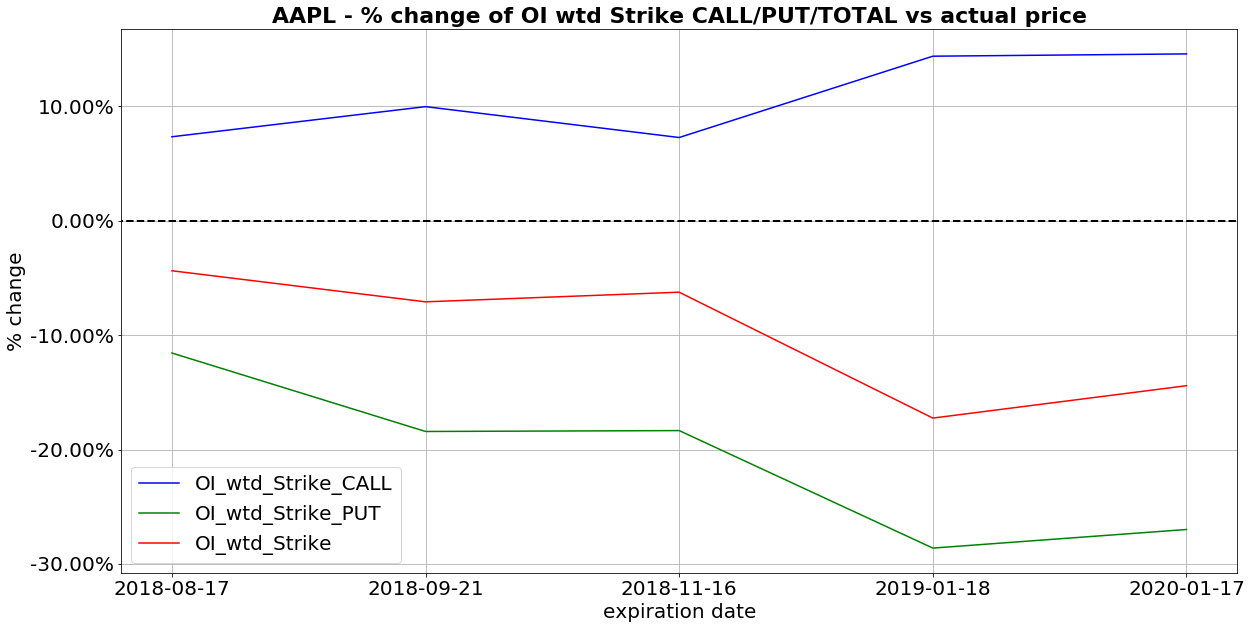

In [14]:
## seleccionar solos los contratos con fechas mayores a 30 días


date_now = datetime.datetime.now().date()#.time()#, "%m/%d/%y")
start_date = date_now + datetime.timedelta(days=30)
oi_wtd_strike_TOP5=oi_wtd_strike[oi_wtd_strike.index>str(start_date)].sort_values("All_Open Interest",ascending=False).head(5)
oi_wtd_strike_TOP5=oi_wtd_strike_TOP5.sort_index()


f, ax1 = plt.subplots(1, sharex=True, figsize=(20,10))
#plt.legend(loc=2, prop={'size': 20})

ax1.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike_CALL"],color="b",label="OI_wtd_Strike_CALL")
ax1.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike_PUT"],color="g",label="OI_wtd_Strike_PUT")
ax1.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike"],color="r",label="OI_wtd_Strike")

ax1.axhline(y=0, xmin=-1, xmax=1, color='black', linestyle='--', lw=2)

ax1.set_xlabel('expiration date' ,fontsize=20)
ax1.set_ylabel('% change' ,fontsize=20)
ax1.set_title( ticker+' - % change of OI wtd Strike CALL/PUT/TOTAL vs actual price',fontsize=22, fontweight='bold')
ax1.tick_params(labelsize = 20)

## Format axis y
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax1.legend( fontsize=20,loc='best')#shadow=True,
#
ax1.grid()
plt.show()

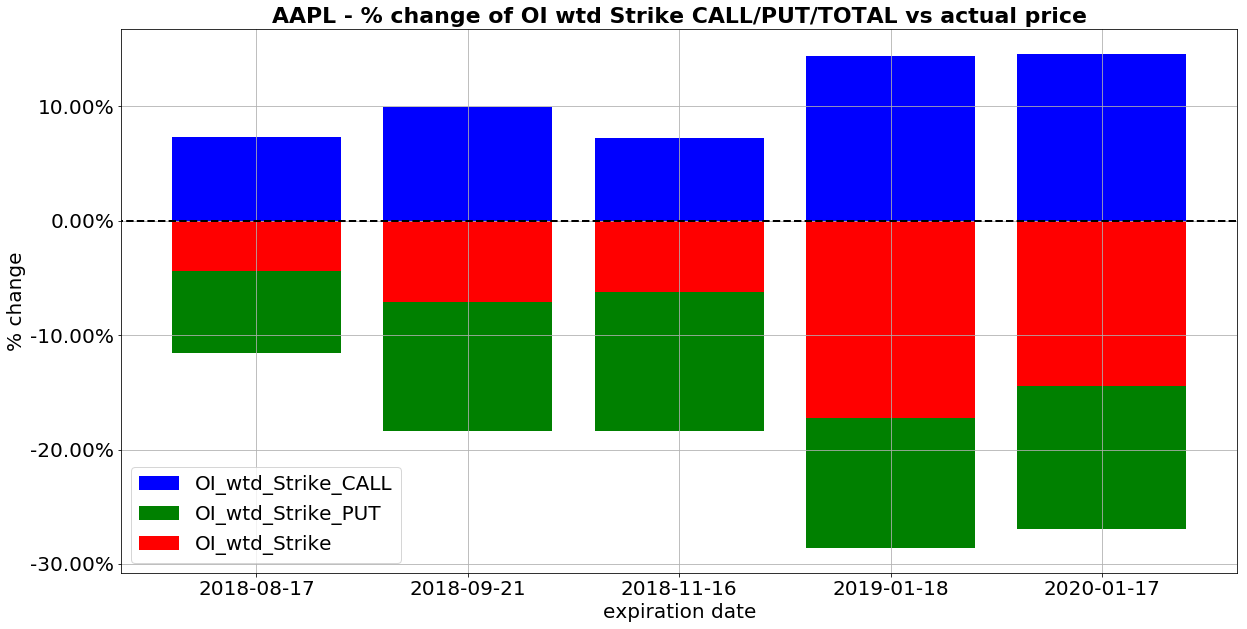

In [15]:

f, ax1 = plt.subplots(1, sharex=True, figsize=(20,10))

ax1.bar(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike_CALL"],color="b",label="OI_wtd_Strike_CALL")
ax1.bar(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike_PUT"],color="g",label="OI_wtd_Strike_PUT")
ax1.bar(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike"],color="r",label="OI_wtd_Strike")

ax1.axhline(y=0, xmin=-1, xmax=1, color='black', linestyle='--', lw=2)

ax1.set_xlabel('expiration date' ,fontsize=20)
ax1.set_ylabel('% change' ,fontsize=20)
ax1.set_title( ticker+' - % change of OI wtd Strike CALL/PUT/TOTAL vs actual price',fontsize=22, fontweight='bold')
ax1.tick_params(labelsize = 20)

## Format axis y
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax1.legend( fontsize=20,loc='best')#shadow=True,
#
ax1.grid()
plt.show()

# 2. Open Interest CALL/PUT

In [16]:
#oi_wtd_strike
#oi_wtd_strike.head()

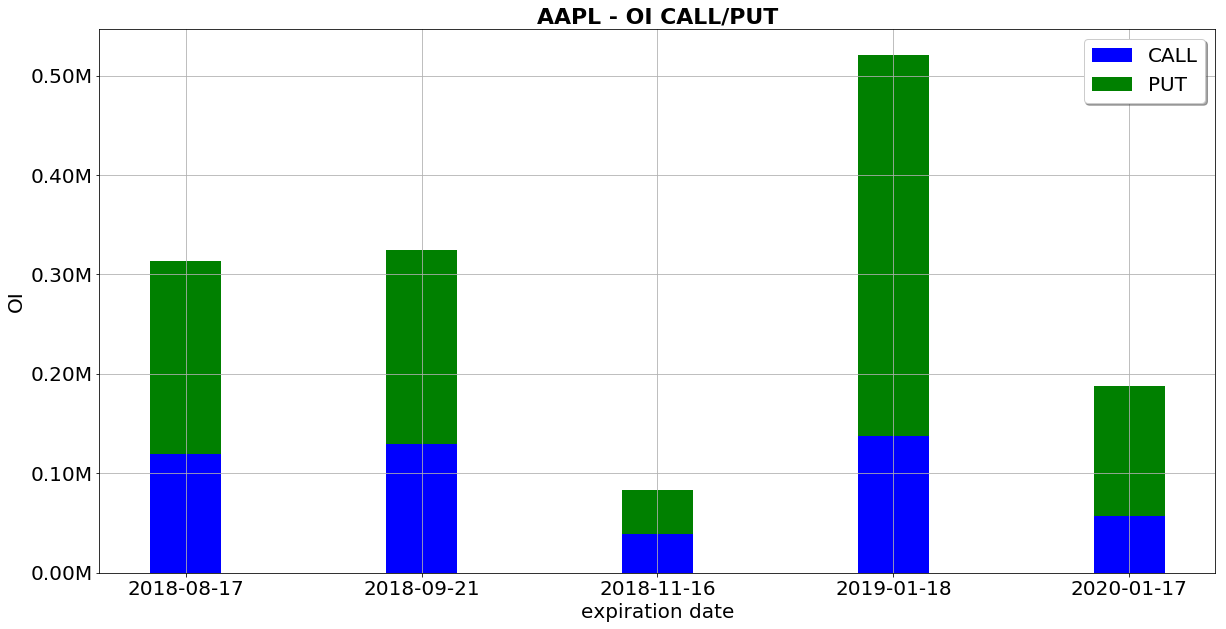

In [17]:
#date_now = datetime.datetime.now().date()#.time()#, "%m/%d/%y")
#start_date = date_now + datetime.timedelta(days=30)
OI=oi_wtd_strike[oi_wtd_strike.index>str(start_date)].sort_values("All_Open Interest",ascending=False).head(5)
OI=OI.sort_index()

f, ax2 = plt.subplots(1, sharex=True, figsize=(20,10))

CALL_data = OI["call_Open Interest"]
PUT_data = OI["put_Open Interest"]
ind = OI.index    # the x locations for the groups
width = .3       # the width of the bars: can also be len(x) sequence

ax2.bar(OI.index.strftime('%Y-%m-%d'), CALL_data ,width=width, color="b",label="CALL")# , width
ax2.bar(OI.index.strftime('%Y-%m-%d'), PUT_data  ,bottom=CALL_data, width=width,color="g",label="PUT" )#width

ax2.set_xlabel("expiration date", fontsize=20)
ax2.set_ylabel('OI', fontsize=20)
ax2.set_title(ticker+' - OI CALL/PUT', fontsize=22, fontweight='bold')
ax2.legend(shadow=True, fontsize=20,loc='best')
ax2.tick_params(labelsize = 20)

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.2fM' % (x*1e-6)

formatter = mticker.FuncFormatter(millions)
ax2.get_yaxis().set_major_formatter(formatter)
ax2.grid()

# 3.Implied Volatility over time for all expiration dates

In [18]:
#table2.columns

In [19]:
#aux_options.head()
#pd.DataFrame(table2.groupby(level=0).sum()["Open Interest"])
#table2.groupby(level=0).sum()

In [20]:

#table2 = pd.pivot_table(aux_options, values=['B/A Spread %'], index=['expiration',"Strike"],columns=['type'], aggfunc=np.average,margins=True).reset_index("Strike")
#table2 = table2[table2.index!="All"]

# delete index "all"
#table2 = table2[table.index.get_level_values('expiration')!="All"]#.set_index(["expiration",'Strike']) 

#table=flatten_multi_index(table).reset_index("Strike")
#table2.head()



## pivot table by expiration date and iv
table1 = pd.pivot_table(aux_options, values=['Open Interest'], index=['expiration',"Strike"],columns=['type'], aggfunc=np.sum,margins=True)#.reset_index("Implied Volatility")
table2 = pd.pivot_table(aux_options, values=['Implied Volatility'], index=['expiration',"Strike"],columns=['type'], aggfunc=np.average,margins=True)#.reset_index("Implied Volatility")

# delete index "all"
table1 = table1[table1.index.get_level_values('expiration')!="All"]
table2 = table2[table2.index.get_level_values('expiration')!="All"]

table1=flatten_multi_index(table1)
table2=flatten_multi_index(table2)#.reset_index('Implied Volatility')#("Open Interest")

table2=pd.merge(table1,table2,left_index=True,right_index=True)

## OI * IV
table2["call_OI_x_IV"]=table2["call_Implied Volatility"]*table2["call_Open Interest"]
table2["put_OI_x_IV"]=table2["put_Implied Volatility"]*table2["put_Open Interest"]
table2["total_OI_x_IV"]=table2["All_Implied Volatility"]*table2["All_Open Interest"]
#table2.head()

# Sort values by exp date and strike.
#table = table2.reset_index().sort_values(["expiration","Open Interest"], ascending=[1,1]).set_index(["expiration",'Open Interest'])#.set_index(["expiration"])###,'Strike'

## Total by  (only )date  OI_wtd_Strike  (OI * STRIKE/ OI)
oi_total=pd.DataFrame(table2.groupby(level=0).sum()["All_Open Interest"])
total_strike=pd.DataFrame(table2.groupby(level=0)["total_OI_x_IV"].sum())#.reset_index()
total_oi_wtd_strike=pd.concat([oi_total,total_strike],axis=1)
total_oi_wtd_strike["OI_wtd_IV"]=total_oi_wtd_strike["total_OI_x_IV"]/total_oi_wtd_strike["All_Open Interest"]
#total_oi_wtd_strike=pd.DataFrame(total_oi_wtd_strike["OI_wtd_Strike"])

# put by date
oi_put=pd.DataFrame(table2.groupby(level=0).sum()["put_Open Interest"])
put_strike=pd.DataFrame(table2.groupby(level=0)["put_OI_x_IV"].sum())#.reset_index()
put_oi_wtd_strike=pd.concat([oi_put,put_strike],axis=1)
put_oi_wtd_strike["OI_wtd_IV_PUT"]=put_oi_wtd_strike["put_OI_x_IV"]/put_oi_wtd_strike["put_Open Interest"]
#put_oi_wtd_strike=pd.DataFrame(put_oi_wtd_strike["OI_wtd_Strike_PUT"])

# call
oi_call=pd.DataFrame(table2.groupby(level=0).sum()["call_Open Interest"])
call_strike=pd.DataFrame(table2.groupby(level=0)["call_OI_x_IV"].sum())#.reset_index()
call_oi_wtd_strike=pd.concat([oi_call,call_strike],axis=1)
call_oi_wtd_strike["OI_wtd_IV_CALL"]=call_oi_wtd_strike["call_OI_x_IV"]/call_oi_wtd_strike["call_Open Interest"]
#call_oi_wtd_strike=pd.DataFrame(call_oi_wtd_strike["OI_wtd_Strike_CALL"])

## unir total, call, put
oi_wtd_iv=pd.concat([call_oi_wtd_strike,put_oi_wtd_strike,total_oi_wtd_strike],axis=1)
oi_wtd_iv.head()

,call_Open Interest,call_OI_x_IV,OI_wtd_IV_CALL,put_Open Interest,put_OI_x_IV,OI_wtd_IV_PUT,All_Open Interest,total_OI_x_IV,OI_wtd_IV
expiration,,,,,,,,,
2018-07-20,230868.0,69489.9213,0.300994,347291.0,156352.6986,0.450207,578159,225842.6199,0.390624
2018-07-27,20325.0,3701.4390,0.182113,18816.0,4587.7852,0.243824,39141,8289.2242,0.211779
2018-08-03,13781.0,3579.1086,0.259713,13469.0,4070.1108,0.302184,27250,7649.2194,0.280705
2018-08-10,4933.0,1110.3717,0.225091,10564.0,3601.3231,0.340905,15497,4711.6948,0.304039
2018-08-17,119321.0,25845.0946,0.216601,194310.0,58043.7743,0.298717,313631,83888.8689,0.267476


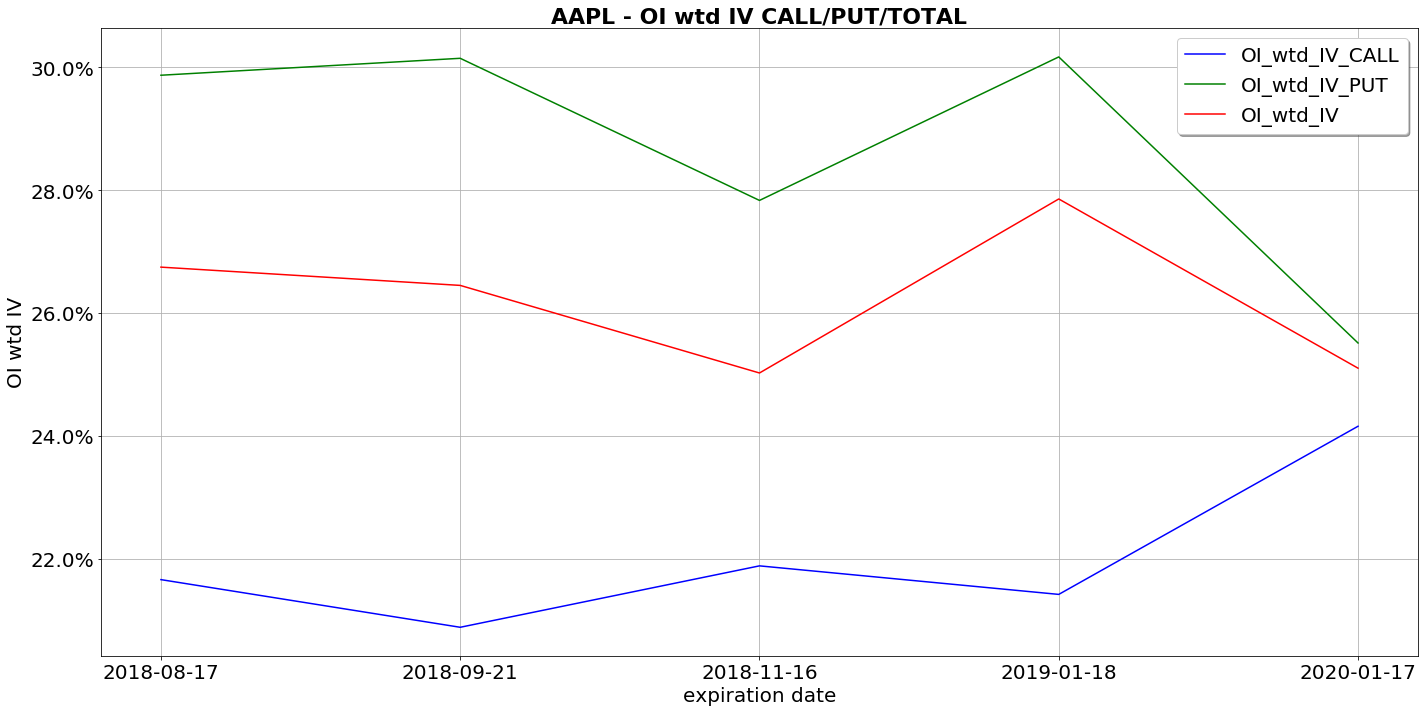

In [21]:
oi_wtd_iv_TOP5=oi_wtd_iv[oi_wtd_iv.index>str(start_date)].sort_values("All_Open Interest",ascending=False).head(5)
oi_wtd_iv_TOP5=oi_wtd_iv_TOP5.sort_index()


f, ax3 = plt.subplots(1, sharex=True, figsize=(20,10))

ax3.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_iv_TOP5["OI_wtd_IV_CALL"],color="b",label="OI_wtd_IV_CALL")
ax3.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_iv_TOP5["OI_wtd_IV_PUT"],color="g",label="OI_wtd_IV_PUT")
ax3.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_iv_TOP5["OI_wtd_IV"],color="r",label="OI_wtd_IV")

'''pos = list(range(len(oi_wtd_iv_TOP5))) 
width = 0.15 #oi_wtd_iv_TOP5.index.strftime('%Y-%m-%d')
ax3.bar([p - width for p in pos],oi_wtd_iv_TOP5["OI_wtd_IV_CALL"], color='b', label="OI_wtd_IV_CALL",width=width)#alpha=0.5,
ax3.bar(pos,oi_wtd_iv_TOP5["OI_wtd_IV_PUT"], color='g', label="OI_wtd_IV_PUT",width=width)
ax3.bar([p + width for p in pos],oi_wtd_iv_TOP5["OI_wtd_IV"], color='r', label="OI_wtd_IV",width=width)
ax.set_xticks([p + 1.5 * width for p in pos])'''

ax3.set_ylabel("OI wtd IV", fontsize=20)
ax3.set_xlabel("expiration date", fontsize=20)
ax3.set_title(ticker+' - OI wtd IV CALL/PUT/TOTAL', fontsize=22, fontweight='bold')
ax3.legend(shadow=True, fontsize=20)
ax3.tick_params(labelsize = 20)

def pct(x, pos):
    'The two args are the value and tick position'
    return '%.1f%%' % (x*100)

formatter = mticker.FuncFormatter(pct)
ax3.get_yaxis().set_major_formatter(formatter)
ax3.grid()
f.tight_layout()

plt.show()

In [22]:
#aux[["OI_wtd_IV_CALL","OI_wtd_IV_PUT","OI_wtd_IV"]]

In [23]:
'''ax = oi_wtd_iv_TOP5[["OI_wtd_IV_CALL","OI_wtd_IV_PUT","OI_wtd_IV"]].plot(figsize=(15,7),title='OI wtd IV CALL/PUT/TOTAL - '+ticker,kind='bar')
ticklabels = ['']*len(oi_wtd_iv_TOP5)
ticklabels = oi_wtd_iv_TOP5.index.strftime('%Y-%m-%d')
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
ax.set_ylabel("OI wtd IV")
ax.set_xlabel("expiration date")
#ax.axhline(y=aux.OI_wtd_IV, color='black', linestyle='--', lw=2)# xmin=-1, xmax=1,'''

'ax = oi_wtd_iv_TOP5[["OI_wtd_IV_CALL","OI_wtd_IV_PUT","OI_wtd_IV"]].plot(figsize=(15,7),title=\'OI wtd IV CALL/PUT/TOTAL - \'+ticker,kind=\'bar\')\nticklabels = [\'\']*len(oi_wtd_iv_TOP5)\nticklabels = oi_wtd_iv_TOP5.index.strftime(\'%Y-%m-%d\')\nax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))\nax.set_ylabel("OI wtd IV")\nax.set_xlabel("expiration date")\n#ax.axhline(y=aux.OI_wtd_IV, color=\'black\', linestyle=\'--\', lw=2)# xmin=-1, xmax=1,'

# 4. Volumen wtd Spread

In [24]:
#table2

In [25]:
#aux_options_clean=aux_options.replace([np.inf, -np.inf], np.nan).dropna(subset=["B/A Spread %"] ,how="all")

'''
table2 = pd.pivot_table(aux_options, values=['B/A Spread %'], index=['expiration',"Strike"],columns=['type'], aggfunc=np.average,margins=True)#.reset_index("Strike")
table2 = table2[table2.index!="All"]
table2.loc[:,("B/A Spread %",'put')]=table2["B/A Spread %"]["put"].fillna(0)*100
table2.loc[:,("B/A Spread %",'call')]=table2["B/A Spread %"]["call"].fillna(0)*100
table2.loc[:,("B/A Spread %",'All')]=table2["B/A Spread %"]["All"].fillna(0)*100
#table2["Implied Volatility"]["call"]=table2["Implied Volatility"]["call"]*100
#table2["total_IV"]=(table2['Implied Volatility']["call"].fillna(0)+table2['Implied Volatility']["put"].fillna(0))/2
#table1 = table[["Open Interest","total"]]#.loc[table2.index]

table1 = pd.pivot_table(aux_options, values=['Volume'], index=['expiration',"Strike"],columns=['type'], aggfunc=np.sum,margins=True)#.reset_index("Strike")
table1_ = table1[table1.index!="All"]
table1_


table3=pd.concat([table1_,table2],axis=1).reset_index("Strike")

table3["Vol_Spread_PUT"]=table3["Volume"]["put"]*table3["B/A Spread %"]["put"]
table3["Vol_Spread_CALL"]=table3["Volume"]["call"]*table3["B/A Spread %"]["call"]
table3["Vol_Spread"]=table3["Volume"]["All"]*table3["B/A Spread %"]["All"]
table3.head()

oi_total=pd.DataFrame(table3.groupby(level=0).sum()["Volume"]["All"])
total_oi=pd.DataFrame(table3.groupby(level=0)["Vol_Spread"].sum())#/100#.reset_index()
total_oi_wtd_Spread=pd.concat([oi_total,total_oi],axis=1)
total_oi_wtd_Spread["Vol_wtd_Spread"]=total_oi_wtd_Spread["Vol_Spread"]/total_oi_wtd_Spread["All"]
#total_oi_wtd_iv=pd.DataFrame(total_oi_wtd_iv["OI_wtd_IV"])
total_oi_wtd_Spread.tail()


oi_put=pd.DataFrame(table3.groupby(level=0).sum()["Volume"]["put"])
put_oi=pd.DataFrame(table3.groupby(level=0)["Vol_Spread_PUT"].sum())#.reset_index()
put_oi_wtd_Spread=pd.concat([oi_put,put_oi],axis=1)
put_oi_wtd_Spread["Vol_wtd_Spread_PUT"]=put_oi_wtd_Spread["Vol_Spread_PUT"]/put_oi_wtd_Spread["put"]
#put_oi_wtd_iv=pd.DataFrame(put_oi_wtd_iv["OI_wtd_IV_PUT"])
put_oi_wtd_Spread.head()

oi_call=pd.DataFrame(table3.groupby(level=0).sum()["Volume"]["call"])
call_oi=pd.DataFrame(table3.groupby(level=0)["Vol_Spread_CALL"].sum())#.reset_index()
call_oi_wtd_Spread=pd.concat([oi_call,call_oi],axis=1)
call_oi_wtd_Spread["Vol_wtd_Spread_CALL"]=call_oi_wtd_Spread["Vol_Spread_CALL"]/call_oi_wtd_Spread["call"]
#call_oi_wtd_iv=pd.DataFrame(call_oi_wtd_iv["OI_wtd_IV_CALL"])
call_oi_wtd_Spread.head()

vol_wtd_Spread=pd.concat([call_oi_wtd_Spread,put_oi_wtd_Spread,total_oi_wtd_Spread],axis=1)
vol_wtd_Spread=vol_wtd_Spread.replace([np.inf, -np.inf], np.nan).dropna(subset=["Vol_wtd_Spread"] ,how="all")

#oi_wtd_Spread.head()
vol_wtd_Spread.head()'''

'\ntable2 = pd.pivot_table(aux_options, values=[\'B/A Spread %\'], index=[\'expiration\',"Strike"],columns=[\'type\'], aggfunc=np.average,margins=True)#.reset_index("Strike")\ntable2 = table2[table2.index!="All"]\ntable2.loc[:,("B/A Spread %",\'put\')]=table2["B/A Spread %"]["put"].fillna(0)*100\ntable2.loc[:,("B/A Spread %",\'call\')]=table2["B/A Spread %"]["call"].fillna(0)*100\ntable2.loc[:,("B/A Spread %",\'All\')]=table2["B/A Spread %"]["All"].fillna(0)*100\n#table2["Implied Volatility"]["call"]=table2["Implied Volatility"]["call"]*100\n#table2["total_IV"]=(table2[\'Implied Volatility\']["call"].fillna(0)+table2[\'Implied Volatility\']["put"].fillna(0))/2\n#table1 = table[["Open Interest","total"]]#.loc[table2.index]\n\ntable1 = pd.pivot_table(aux_options, values=[\'Volume\'], index=[\'expiration\',"Strike"],columns=[\'type\'], aggfunc=np.sum,margins=True)#.reset_index("Strike")\ntable1_ = table1[table1.index!="All"]\ntable1_\n\n\ntable3=pd.concat([table1_,table2],axis=1).reset_in

# SUMMARY (PLOTS)

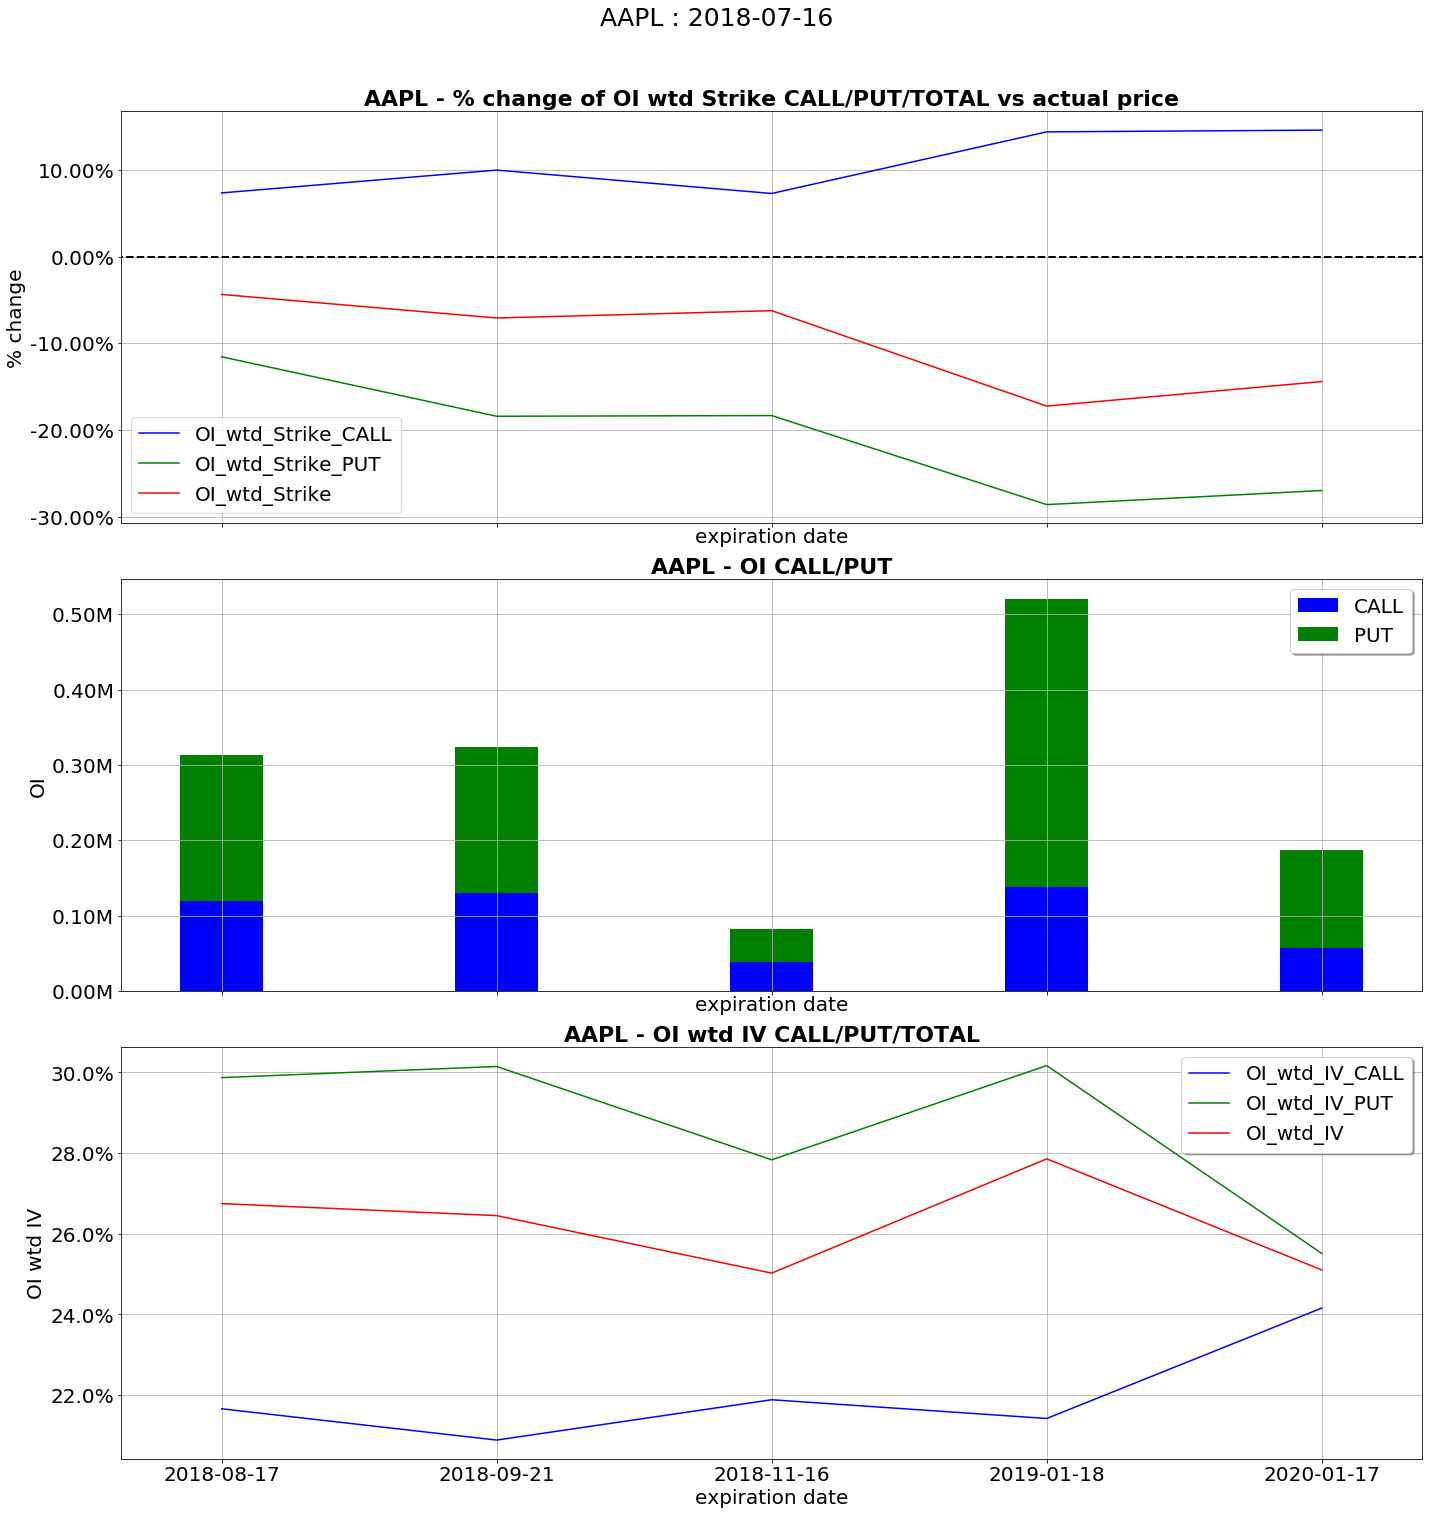

In [26]:
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,20))
f.suptitle(ticker+' : '+str(date_now),y=1.05, fontsize=25) #  "2018 - 07 - 11"
#plt.legend(loc=2, prop={'size': 20})

ax1.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike_CALL"],color="b",label="OI_wtd_Strike_CALL")
ax1.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike_PUT"],color="g",label="OI_wtd_Strike_PUT")
ax1.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_strike_TOP5["pct_OI_wtd_Strike"],color="r",label="OI_wtd_Strike")

ax1.axhline(y=0, xmin=-1, xmax=1, color='black', linestyle='--', lw=2)

ax1.set_xlabel('expiration date' ,fontsize=20)
ax1.set_ylabel('% change' ,fontsize=20)
ax1.set_title( ticker+' - % change of OI wtd Strike CALL/PUT/TOTAL vs actual price',fontsize=22, fontweight='bold')
ax1.tick_params(labelsize = 20)

## Format axis y
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax1.legend( fontsize=20,loc='best')#shadow=True,
ax1.grid()


CALL_data = OI["call_Open Interest"]
PUT_data = OI["put_Open Interest"]
ind = OI.index    # the x locations for the groups
width = .3       # the width of the bars: can also be len(x) sequence

ax2.bar(OI.index.strftime('%Y-%m-%d'), CALL_data ,width=width, color="b",label="CALL")# , width
ax2.bar(OI.index.strftime('%Y-%m-%d'), PUT_data  ,bottom=CALL_data, width=width,color="g",label="PUT" )#width

ax2.set_xlabel("expiration date", fontsize=20)
ax2.set_ylabel('OI', fontsize=20)
ax2.set_title(ticker+' - OI CALL/PUT', fontsize=22, fontweight='bold')
ax2.legend(shadow=True, fontsize=20,loc='best')
ax2.tick_params(labelsize = 20)

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.2fM' % (x*1e-6)

formatter = mticker.FuncFormatter(millions)
ax2.get_yaxis().set_major_formatter(formatter)
ax2.grid()






ax3.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_iv_TOP5["OI_wtd_IV_CALL"],color="b",label="OI_wtd_IV_CALL")
ax3.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_iv_TOP5["OI_wtd_IV_PUT"],color="g",label="OI_wtd_IV_PUT")
ax3.plot(oi_wtd_strike_TOP5.index.strftime('%Y-%m-%d'),oi_wtd_iv_TOP5["OI_wtd_IV"],color="r",label="OI_wtd_IV")

ax3.set_ylabel("OI wtd IV", fontsize=20)
ax3.set_xlabel("expiration date", fontsize=20)
ax3.set_title(ticker+' - OI wtd IV CALL/PUT/TOTAL', fontsize=22, fontweight='bold')
ax3.legend(shadow=True, fontsize=20)
ax3.tick_params(labelsize = 20)

def pct(x, pos):
    'The two args are the value and tick position'
    return '%.1f%%' % (x*100)

formatter = mticker.FuncFormatter(pct)
ax3.get_yaxis().set_major_formatter(formatter)
ax3.grid()
f.tight_layout()

plt.show()
